In [ ]:
!pip install gymnasium==1.0.0 moviepy==1.0.3

!pip install ipython-autotime
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1-0fhqH8tXKPb60C_b4aUHT7f-J4O6Ezq
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.2 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-0fhqH8tXKPb60C_b4aUHT7f-J4O6Ezq
From (redirected): https://drive.google.com/uc?id=1-0fhqH8tXKPb60C_b4aUHT7f-J4O6Ezq&confirm=t&uuid=1037589a-a46f-44d8-a2a9-cc2bf9717979
To: /content/dataset_labels.npz
100% 31.4M/31.4M [00:00<00:00, 42.3MB/s]
time: 372 µs (started: 2025-02-02 18:24:18 +00:00)


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
from IPython.display import Video
from moviepy.editor import ImageSequenceClip
from google.colab import files
import imageio
import time

# Install gdown if not already installed
!pip install gdown --upgrade --quiet

# Download the zip file
!gdown 1-GO8oCJtu97sGyxw9M8fsJHw6TFzmHPd -O explainer.zip

# Unzip the file
!unzip -q explainer.zip -d explainer




Downloading...
From: https://drive.google.com/uc?id=1-GO8oCJtu97sGyxw9M8fsJHw6TFzmHPd
To: /content/explainer.zip
100% 1.88k/1.88k [00:00<00:00, 7.56MB/s]
replace explainer/explainer - step1.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-0fhqH8tXKPb60C_b4aUHT7f-J4O6Ezq
From (redirected): https://drive.google.com/uc?id=1-0fhqH8tXKPb60C_b4aUHT7f-J4O6Ezq&confirm=t&uuid=b07b0459-4a80-4e7e-bc51-9632138ea701
To: /content/dataset_labels.npz
100% 31.4M/31.4M [00:00<00:00, 77.6MB/s]
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 25.8 s (started: 2025-02-02 18:24:18 +00:00)


In [ ]:
def create_video(frames, fps=10):
    clip = ImageSequenceClip(frames, fps=fps)
    video_filename = "cartpole_episode.mp4"
    clip.write_videofile(video_filename, fps=fps)
    return video_filename

def plot_rewards_with_avg(rewards, title="Training Progress", avg_window=40):
    """
    Plot the training rewards with an average of the last 'avg_window' episodes in red.
    """
    plt.plot(rewards, label="Episode Rewards", color='blue')
    if len(rewards) >= avg_window:
        avg_rewards = [np.mean(rewards[i:i + avg_window]) for i in range(len(rewards) - avg_window + 1)]
        plt.plot(range(avg_window - 1, len(rewards)), avg_rewards, label=f"Avg Rewards (Last {avg_window})", color='red')
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()


time: 783 µs (started: 2025-02-02 18:24:44 +00:00)


In [ ]:
# Initialize environment with graphical rendering mode
envName = "CartPole-v1"
env = gym.make(envName , render_mode='rgb_array')
video_filename = 'randomRun.mp4'


# Reset the environment
observation, info = env.reset()
print("Initial state:", observation)

state_size = env.observation_space
print("State size is:", state_size)

action_space = env.action_space
print("Action size is:", action_space)

Initial state: [-0.03097945  0.00626123 -0.00260001 -0.04818999]
State size is: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action size is: Discrete(2)
time: 25 ms (started: 2025-02-02 18:24:44 +00:00)


In [ ]:
env = gym.make(envName , render_mode='rgb_array')
observation, info = env.reset()
frames = []
done = False
iter = 0

# Run the episode and render each frame as an image
while not done:
    iter += 1
    action = env.action_space.sample()  # Take a random action
    observation, reward, done, truncated, info = env.step(action)
    frame = env.render()  # Returns a graphical frame
    frames.append(frame)
env.close()

# Save the video file
with imageio.get_writer(video_filename, fps=3) as video:
    for frame in frames:
        video.append_data(frame)

# Display the saved video in the notebook
display(Video(video_filename, embed=True))

time: 504 ms (started: 2025-02-02 18:24:44 +00:00)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout


time: 5.84 s (started: 2025-02-02 18:24:45 +00:00)


In [ ]:
class REINFORCE:
    def __init__(self, env_name='CartPole-v1', learning_rate=0.001, gamma=0.99):
        self.env = gym.make(env_name)
        self.env._max_episode_steps = 500
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma
        self.model = self.build_model(learning_rate)


    def build_model(self, learning_rate):
        model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate))
        return model

    def compute_returns(self, rewards):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = np.array(returns, dtype='float32')
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
        return returns

    def reinforce_loss(self, states, actions, returns):
        probs = self.model(states)
        action_masks = tf.one_hot(actions, self.action_dim)
        selected_action_probs = tf.reduce_sum(probs * action_masks, axis=1)
        log_probs = tf.math.log(selected_action_probs + 1e-8)
        loss = -tf.reduce_mean(log_probs * returns)
        return loss

    def train_episode(self):
        state = self.env.reset()
        if isinstance(state, tuple):
            state = state[0]
        states, actions, rewards = [], [], []
        done = False
        total_reward = 0

        while not done:
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            state_tensor = tf.expand_dims(state_tensor, axis=0)
            action_probs = self.model(state_tensor).numpy()
            action = np.random.choice(self.action_dim, p=action_probs[0])
            step_result = self.env.step(action)
            next_state, reward, done, *_ = step_result
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            total_reward += reward
            state = next_state

            if total_reward >= 500:
                break

        states = np.array(states, dtype='float32')
        actions = np.array(actions, dtype='int32')
        returns = self.compute_returns(rewards)
        with tf.GradientTape() as tape:
            loss = self.reinforce_loss(states, actions, returns)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return total_reward

    def train(self, max_episodes=1000, target_average_reward=480, window=80):
        episode_rewards = []

        for episode in range(max_episodes):
            total_reward = self.train_episode()
            episode_rewards.append(total_reward)

            # Print progress every 10 episodes
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(episode_rewards[-10:])
                print(f"Episode {episode + 1}: Average Reward (last 10): {avg_reward:.2f}")

            # Check for early stopping
            if len(episode_rewards) >= window and np.mean(episode_rewards[-window:]) >= target_average_reward:
                print(f"Environment solved in {episode + 1} episodes! "
                      f"Average reward over the last {window} episodes: "
                      f"{np.mean(episode_rewards[-window:]):.2f}")
                break

        return episode_rewards

    def inference(self, num_episodes=1, render=True):
        """
        Run inference using the trained policy for a given number of episodes.
        """
        for episode in range(num_episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]
            total_reward = 0
            done = False

            while not done:
                if render:
                    self.env.render()

                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = self.model(state_tensor).numpy()
                action = np.argmax(action_probs[0])

                step_result = self.env.step(action)
                if len(step_result) == 4:
                    state, reward, done, _ = step_result
                else:
                    state, reward, done, truncated, _ = step_result
                    done = done or truncated

                total_reward += reward

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        self.env.close()


time: 3.37 ms (started: 2025-02-02 18:24:51 +00:00)


In [ ]:
class REINFORCE_Arch2(REINFORCE):
    def build_model(self, learning_rate):
        model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate))
        return model

class REINFORCE_Arch3(REINFORCE):
    def build_model(self, learning_rate):
        model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(24, activation='relu'),
            Dropout(0.2),
            Dense(24, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate))
        return model


time: 916 µs (started: 2025-02-02 18:24:51 +00:00)


Episode 10: Average Reward (last 10): 20.70
Episode 20: Average Reward (last 10): 22.50
Episode 30: Average Reward (last 10): 22.50
Episode 40: Average Reward (last 10): 25.80
Episode 50: Average Reward (last 10): 30.60
Episode 60: Average Reward (last 10): 20.40
Episode 70: Average Reward (last 10): 23.00
Episode 80: Average Reward (last 10): 31.20
Episode 90: Average Reward (last 10): 27.60
Episode 100: Average Reward (last 10): 26.10
Episode 110: Average Reward (last 10): 27.80
Episode 120: Average Reward (last 10): 30.40
Episode 130: Average Reward (last 10): 30.60
Episode 140: Average Reward (last 10): 24.60
Episode 150: Average Reward (last 10): 31.20
Episode 160: Average Reward (last 10): 30.90
Episode 170: Average Reward (last 10): 39.20
Episode 180: Average Reward (last 10): 36.60
Episode 190: Average Reward (last 10): 38.80
Episode 200: Average Reward (last 10): 33.20
Episode 210: Average Reward (last 10): 34.30
Episode 220: Average Reward (last 10): 32.40
Episode 230: Averag

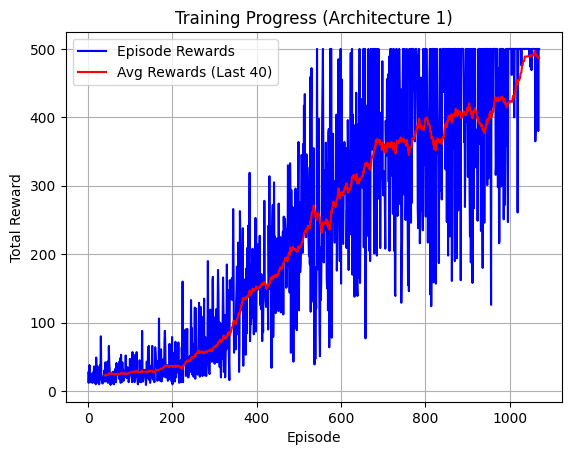

time: 19min 31s (started: 2025-02-02 18:24:51 +00:00)


In [ ]:
# Train Architecture 1
agent1 = REINFORCE(env_name='CartPole-v1')
rewards1 = agent1.train(max_episodes=2000)
plot_rewards_with_avg(rewards1, title="Training Progress (Architecture 1)")
agent1.model.save('reinforce_cartpole_arch1.h5')


Episode 10: Average Reward (last 10): 21.80
Episode 20: Average Reward (last 10): 29.50
Episode 30: Average Reward (last 10): 22.20
Episode 40: Average Reward (last 10): 18.50
Episode 50: Average Reward (last 10): 25.60
Episode 60: Average Reward (last 10): 22.70
Episode 70: Average Reward (last 10): 28.60
Episode 80: Average Reward (last 10): 16.40
Episode 90: Average Reward (last 10): 24.40
Episode 100: Average Reward (last 10): 30.10
Episode 110: Average Reward (last 10): 25.10
Episode 120: Average Reward (last 10): 27.80
Episode 130: Average Reward (last 10): 27.60
Episode 140: Average Reward (last 10): 22.80
Episode 150: Average Reward (last 10): 25.20
Episode 160: Average Reward (last 10): 32.80
Episode 170: Average Reward (last 10): 44.90
Episode 180: Average Reward (last 10): 35.20
Episode 190: Average Reward (last 10): 61.80
Episode 200: Average Reward (last 10): 78.80
Episode 210: Average Reward (last 10): 64.50
Episode 220: Average Reward (last 10): 64.90
Episode 230: Averag

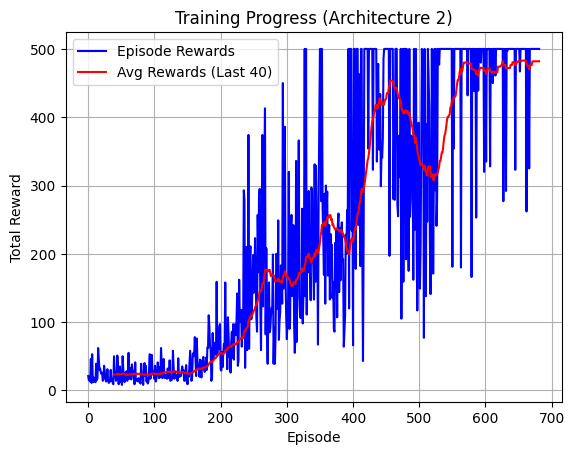

time: 15min 28s (started: 2025-02-02 18:44:22 +00:00)


In [ ]:

# Train Architecture 2
agent2 = REINFORCE_Arch2(env_name='CartPole-v1')
rewards2 = agent2.train(max_episodes=2000)
plot_rewards_with_avg(rewards2, title="Training Progress (Architecture 2)")  # Fixed typo
agent2.model.save('reinforce_cartpole_arch2.h5')

Episode 10: Average Reward (last 10): 23.00
Episode 20: Average Reward (last 10): 22.30
Episode 30: Average Reward (last 10): 19.50
Episode 40: Average Reward (last 10): 28.50
Episode 50: Average Reward (last 10): 28.90
Episode 60: Average Reward (last 10): 25.00
Episode 70: Average Reward (last 10): 29.80
Episode 80: Average Reward (last 10): 25.20
Episode 90: Average Reward (last 10): 32.00
Episode 100: Average Reward (last 10): 40.30
Episode 110: Average Reward (last 10): 44.90
Episode 120: Average Reward (last 10): 30.20
Episode 130: Average Reward (last 10): 25.30
Episode 140: Average Reward (last 10): 37.30
Episode 150: Average Reward (last 10): 28.30
Episode 160: Average Reward (last 10): 27.10
Episode 170: Average Reward (last 10): 36.80
Episode 180: Average Reward (last 10): 42.30
Episode 190: Average Reward (last 10): 35.10
Episode 200: Average Reward (last 10): 28.80
Episode 210: Average Reward (last 10): 31.70
Episode 220: Average Reward (last 10): 29.20
Episode 230: Averag

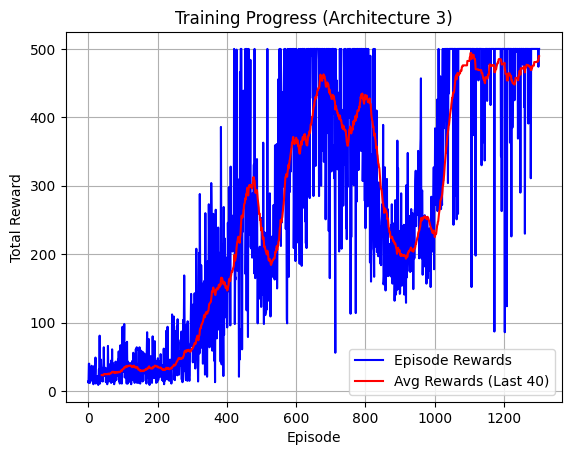

time: 27min 34s (started: 2025-02-02 18:59:50 +00:00)


In [ ]:

# Train Architecture 3
agent3 = REINFORCE_Arch3(env_name='CartPole-v1')
rewards3 = agent3.train(max_episodes=2000)
plot_rewards_with_avg(rewards3, title="Training Progress (Architecture 3)")
agent3.model.save('reinforce_cartpole_arch3.h5')

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import load_model

# To load and run inference later:
# Create a new agent
inference_agent = REINFORCE(env_name='CartPole-v1')

# Load the trained weights
inference_agent.model = load_model('reinforce_cartpole_arch1.h5')

# Run inference
inference_agent.inference(num_episodes=2, render=True)


  gym.logger.warn(



Episode 1: Total Reward: 364.0
Episode 2: Total Reward: 441.0
time: 3.67 s (started: 2025-02-02 19:27:25 +00:00)


In [ ]:
import gym
import tensorflow as tf
import imageio
from IPython.display import Video
import numpy as np

# Initialize the inference agent
inference_agent = REINFORCE(env_name='CartPole-v1')

# Load the trained weights
inference_agent.model = load_model('reinforce_cartpole_arch1.h5')# Run inference

# Set up the environment for rendering
env = gym.make('CartPole-v1', render_mode='rgb_array')
state = env.reset()

if isinstance(state, tuple):  # Handle different gym versions
    state = state[0]

frames = []
done = False
iteration = 0

# Run the episode and render each frame as an image
while not done:
    iteration += 1

    # Get action using the trained policy (argmax instead of sampling)
    state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
    action_probs = inference_agent.model(state_tensor).numpy()
    action = tf.argmax(action_probs[0]).numpy()  # Use the most probable action

    # Step through the environment
    step_result = env.step(action)
    if len(step_result) == 4:
        state, reward, done, _ = step_result
    else:
        state, reward, done, truncated, _ = step_result
        done = done or truncated

    # Render the frame
    frame = env.render()  # Returns a graphical frame

    # Ensure the frame is a numpy array
    if isinstance(frame, list):  # Convert list to numpy array
        frame = np.array(frame)

    # Handle batched frames (select the first frame if batched)
    if frame.ndim == 4:  # Batched format (e.g., (1, 400, 600, 3))
        frame = frame[0]
    elif frame.ndim == 5:  # Unexpected batch format
        raise ValueError(f"Unexpected batch format in frame: {frame.shape}")

    frames.append(frame)

# Close the environment
env.close()



  deprecation(

  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



time: 3.01 s (started: 2025-02-02 19:27:28 +00:00)


In [ ]:
# Save the video file
video_filename = 'cartpole_inference.mp4'
with imageio.get_writer(video_filename, fps=12) as video:
    for frame in frames:
        video.append_data(frame)

# Display the saved video in the notebook
Video(video_filename, embed=True)


  and should_run_async(code)



time: 1.21 s (started: 2025-02-02 19:27:31 +00:00)


**Data Collection for Imitation Learning: Collecting State-Action Pairs and Preparing Datasets**

In [ ]:
import os
import random
import json

# ===============================
# CREATE DIRECTORY FUNCTION
# ===============================
def create_directory(directory_name):

    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        print(f"Directory '{directory_name}' created.")
    else:
        print(f"Directory '{directory_name}' already exists.")

# ===============================
# DATA COLLECTION FUNCTION
# ===============================
def collect_data(agent, num_samples, directory, file_name, ensure_unique=False):
    """
    Collects `num_samples` of (state, action) pairs from the trained agent
    and saves them to a file in the specified directory.

    Args:
        agent: The trained REINFORCE agent.
        num_samples: Number of (state, action) pairs to collect.
        directory:
        file_name: Name of the file to save the collected data.
        ensure_unique: If True, ensures all (state, action) pairs are unique.
    """

    # Step 1: Create the directory if it doesn't exist
    create_directory(directory)

    # Step 2: Initialize variables for data collection
    env = agent.env
    collected_data = []
    seen_states = set()  # To track unique states if required

    # Step 3: Start collecting data until we reach the desired number of samples
    while len(collected_data) < num_samples:
        state = env.reset()
        if isinstance(state, tuple):  # Handle different gym versions
            state = state[0]

        done = False
        while not done and len(collected_data) < num_samples:
            # Convert state to a tuple for uniqueness checking
            state_tuple = tuple(state)

            # Skip duplicates if ensure_unique is True
            if ensure_unique and state_tuple in seen_states:
                break

            # Get the action from the trained policy
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            action_probs = agent.model(state_tensor).numpy()
            action = np.argmax(action_probs[0])

            # Save the (state, action) pair to the list
            collected_data.append({"state": state.tolist(), "action": int(action)})

            # Add the state to the seen set if uniqueness is required
            if ensure_unique:
                seen_states.add(state_tuple)

            # Take a step in the environment
            step_result = env.step(action)
            if len(step_result) == 4:
                state, _, done, _ = step_result
            else:
                state, _, done, truncated, _ = step_result
                done = done or truncated

    # Step 4: Save the collected data to a JSON file
    file_path = os.path.join(directory, file_name)
    with open(file_path, "w") as f:
        json.dump(collected_data, f, indent=4)

    print(f"Collected {len(collected_data)} (state, action) pairs and saved to {file_path}")


# ===============================
# COLLECT DATASETS OF DIFFERENT SIZES
# ===============================

# Step 1: Collect  100, 500, and 1000 examples with high quality (unique examples)
collect_data(agent1, 50, "data_50", "cartpole_data_50.json", ensure_unique=True)
collect_data(agent1, 100, "data_100", "cartpole_data_100.json", ensure_unique=True)
collect_data(agent1, 500, "data_500", "cartpole_data_500.json", ensure_unique=True)
collect_data(agent1, 1000, "data_1000", "cartpole_data_1000.json", ensure_unique=True)

# Step 2: Collect a larger dataset for training (5000 training + 2000 testing)
collect_data(agent1, 7000, "data_7000", "cartpole_data_7000.json", ensure_unique=False)

################################################################################################################

def collect_data_initial_states(agent, num_samples, directory, file_name, ensure_unique=False):
    """
    Collects `num_samples` of (state, action) pairs where the states meet specific criteria
    (e.g., position and angle close to zero), and saves them to a file.

    Args:
        agent: The trained REINFORCE agent.
        num_samples: Number of (state, action) pairs to collect.
        directory: Directory to save the file.
        file_name: Name of the file to save the collected data.
        ensure_unique: If True, ensures all (state, action) pairs are unique.
    """
    # Step 1: Create the directory if it doesn't exist
    create_directory(directory)

    # Step 2: Initialize variables for data collection
    env = agent.env
    collected_data = []
    seen_states = set()  # To track unique states if required

    # Step 3: Define acceptable thresholds for position and angle
    position_threshold = 0.2  # Acceptable range for position near 0
    angle_threshold = 0.2     # Acceptable range for angle near 0

    # Step 4: Start collecting data until we reach the desired number of samples
    while len(collected_data) < num_samples:
        state = env.reset()
        if isinstance(state, tuple):  # Handle different gym versions
            state = state[0]

        done = False
        while not done and len(collected_data) < num_samples:
            # Convert state to a tuple for uniqueness checking
            state_tuple = tuple(state)

            # Extract position and angle from the state
            position, angle = state[0], state[2]

            # Filter states based on position and angle thresholds
            if abs(position) <= position_threshold and abs(angle) <= angle_threshold:
                # Skip duplicates if ensure_unique is True
                if ensure_unique and state_tuple in seen_states:
                    break

                # Get the action from the trained policy
                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = agent.model(state_tensor).numpy()
                action = np.argmax(action_probs[0])

                # Save the (state, action) pair to the list
                collected_data.append({"state": state.tolist(), "action": int(action)})

                # Add the state to the seen set if uniqueness is required
                if ensure_unique:
                    seen_states.add(state_tuple)

            # Take a step in the environment
            step_result = env.step(action)
            if len(step_result) == 4:
                state, _, done, _ = step_result
            else:
                state, _, done, truncated, _ = step_result
                done = done or truncated

    # Step 5: Save the collected data to a JSON file
    file_path = os.path.join(directory, file_name)
    with open(file_path, "w") as f:
        json.dump(collected_data, f, indent=4)

    print(f"Collected {len(collected_data)} (state, action) pairs and saved to {file_path}")


collect_data_initial_states(agent1, 50, "data_50_filtered", "cartpole_data_50_filtered.json", ensure_unique=True)



Directory 'data_50' created.
Collected 50 (state, action) pairs and saved to data_50/cartpole_data_50.json
Directory 'data_100' created.
Collected 100 (state, action) pairs and saved to data_100/cartpole_data_100.json
Directory 'data_500' created.
Collected 500 (state, action) pairs and saved to data_500/cartpole_data_500.json
Directory 'data_1000' created.
Collected 1000 (state, action) pairs and saved to data_1000/cartpole_data_1000.json
Directory 'data_7000' created.
Collected 7000 (state, action) pairs and saved to data_7000/cartpole_data_7000.json
Directory 'data_50_filtered' created.
Collected 50 (state, action) pairs and saved to data_50_filtered/cartpole_data_50_filtered.json
time: 36.9 s (started: 2025-02-02 19:27:33 +00:00)
